# Projeto da III Unidade de PI Contagem de hemácias

### Alunos

- Gabriel Silva de Jesus
- Gustavo Henrique Aragão Silva

---

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import pandas as pd # Usado para plotar tabelas python


Leitura de uma imagem para descobrir detalhes iniciais:

In [42]:
nome_image = './imgs/BloodImage_00408.jpg'

image_color = io.imread(nome_image)


----
### Passo 1 - Extração dos Leucócitos para Isolar as Hemácias
1.1. Seguindo a sugestão do professor, exploramos os canais HSV e nos concentramos especialmente no canal H, que define a cor. Dessa forma, seremos capazes de remover os leucócitos. Para isso, buscamos os valores máximos de H presentes em uma imagem fornecida.


In [43]:
hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(hsv)

# Encontrar o valor máximo de HSV
max_h, max_s, max_v = np.max(h), np.max(s), np.max(v)

print("Valor máximo de H S V respectivamente:", max_h, max_s, max_v)

Valor máximo de H S V respectivamente: 179 157 244


1.2. Após identificarmos os valores máximos, realizamos a variação no canal H para encontrar o intervalo (160 a 179) no qual os leucócitos estão presentes. Em seguida, obtivemos o conjunto complementar, que consiste apenas nas hemácias.

```
lower = np.array([160, 0, 0])
upper = np.array([180, 160, 250])
```

Observação: Por segurança, arredondamos para cima usando a dezena mais próxima do HSV encontrado isso nao altera em nada a nossa implementação.

-  1.2.0 A função abaixo cria uma mascara dado intevalos inferiores e superiores 

In [44]:
def manual_inRange(hsv, lower, upper):

    h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    
    h_mask = np.logical_and(h >= lower[0], h <= upper[0])
    s_mask = np.logical_and(s >= lower[1], s <= upper[1])
    v_mask = np.logical_and(v >= lower[2], v <= upper[2])
    
    return (h_mask & s_mask & v_mask).astype(np.uint8) * 255

- 1.2.1 A função abaixo faz a operação de bitwise em uma imagem e uma máscara fornecida como base, se o parâmetro `negacao=True` quer dizer que estaremos aplicando a operação de not na máscara para que a imagem a ser obtida seja complementar a do intervalo h inicialmente selecionado.



In [45]:
def manual_bitwise_and(img1, mask, negacao=False):
    if  img1.shape[:2] != mask.shape[:2]:
        raise ValueError("I tamaho das imagens e da mascara deve ser iguais.")
    
    h, w, _ = img1.shape

    result_img = np.zeros((h, w, _), dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            # pega o complementar da imagem ou não a partir do complementar da mascara
            mask_tratada = ~mask[i, j] if negacao else mask[i, j]  
            result_img[i, j] = img1[i, j] & mask_tratada # Aplica o bitwise
    
    return result_img

- 1.2.2 Por fim,  função abaixo identifica e remove os leucócitos da imagemn dada, deixando somente as hemácias que é a parte que queremos :)

In [46]:
def RemoveGlobulosBrancos(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Intervalo que se encontram os globulos brancos
    lower = np.array([160, 0, 0]) 
    upper = np.array([180, 160, 250])

    mask = manual_inRange(hsv, lower, upper) # obtém a mascara com o interva

    # Faz a limpeza de ruidos que ficam na imagem. Aplicando o fechamento e após a abertura
    b = np.ones((12,12),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, b)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, b)
   
    return manual_bitwise_and(img, mask=mask, negacao=True) 


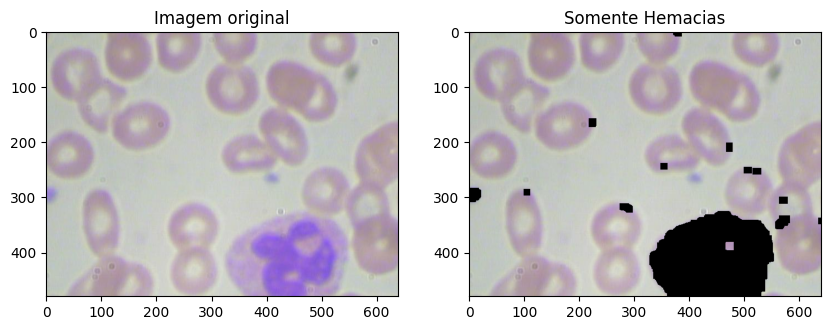

In [47]:
# testando
img_hemacias = RemoveGlobulosBrancos(image_color)

def plotarTeste(img1, msg1, img2, msg2):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
  fig.subplots_adjust(hspace= .2, wspace= .2)

  ax[0].imshow(img1)
  ax[0].set_title(msg1)

  ax[1].imshow(img2)
  ax[1].set_title(msg2)

plotarTeste(image_color, 'Imagem original', img_hemacias, 'Somente Hemacias')

----

### Passo 2 - Pré-processamento mais tratamento e limiarização das imagens.

2.1 A função abaixo faz o pré-processamento da imagem aplicando os seguintes métodos na imagem fornecida:

1. Conversão para níveis de cinza;
2. Equalização histogrâmica, que serve para melhoar o contraste das células em relação ao seu background, ajudando mais tarde na binarização da imagem;
3. Filtro gaussiano, que reduz o ruído e ajuda a detectar as bordas das células, auxiliando também no threshold.

In [48]:
def preprocessamento(hemacias):

    # Conversão para cinza
    gray_redCells = cv2.cvtColor(hemacias, cv2.COLOR_BGR2GRAY)
    
    # Equaliza a imagem
    eq_img = cv2.equalizeHist(gray_redCells)

    # Aplica o filtro gaussiano 5x5 pra remover ruidos indesejados
    k_mask_gaussian = 5
    mask_gaussian = (k_mask_gaussian, k_mask_gaussian)
    gaussian_img = cv2.GaussianBlur(eq_img, mask_gaussian, 0)

    return gray_redCells, eq_img, gaussian_img


2.2 A função meu_adaptiveThreshold implementa um algoritmo de limiarização adaptativa em imagens em tons de cinza. Ela calcula limiares localmente com base na média ou no desvio padrão dos valores de intensidade em regiões específicas da imagem. Dependendo do método escolhido, o limiar é ajustado pela média ou pela média operada com o desvio padrão. 

No nosso projeto testamos tanto a média quanto o desvio padrão e com base  nos testes e  optamos pela média pois foi ela que nos deu a melhor acurácia.

In [49]:
def meu_adaptiveThreshold(img, max_level, metodo, type_threshold, block_size, C):
    
    tamanho_borda = block_size // 2

    # Adiciona borda à imagem de entrada
    borda_img = np.pad(img, tamanho_borda, mode='constant')

    img_saida = np.zeros_like(img)

    j, i = img.shape
    for y in range(tamanho_borda, j + tamanho_borda):
        for x in range(tamanho_borda, i + tamanho_borda):
            regiao_sele = borda_img[y - tamanho_borda:y + tamanho_borda + 1, x - tamanho_borda:x + tamanho_borda + 1]
            
            if metodo == 0:
                threshold_value = np.mean(regiao_sele) - C # Aplica o threshold da media
            else:
                 # aplica o threshold com desvio padrao
                threshold_value = np.mean(regiao_sele) - C * np.std(regiao_sele) / block_size
            
            # Essa região aplica a binarização se satisfeita as condições da região
            if type_threshold == 0:
                img_saida[y - tamanho_borda, x - tamanho_borda] = max_level if img[y - tamanho_borda, x - tamanho_borda] > threshold_value else 0
            
            else:
                img_saida[y - tamanho_borda, x - tamanho_borda] = 0 if img[y - tamanho_borda, x - tamanho_borda] > threshold_value else max_level
    
    return img_saida



2.3. A função a seguir recebe uma imagem já pré-processada e aplica o threshold adaptativo. Em seguida, realiza uma operação de erosão para remover ruídos e, por fim, retorna o inverso da imagem.

Essa função nos fornecerá a imagem limiarizada, permitindo-nos reconhecer círculos de um determinado raio e perímetro. A padronização dessa função para se adequar ao nosso projeto será explicada no Passo 3.

In [50]:
def binariza_imagem(img_processada):
    '''
    Binariza a imagem  de forma adaptativa com o uso do método obtivemos os 
    melhores resultados para as imagens selecionadas ajustamos para 
    '''

    img_binary = meu_adaptiveThreshold(img_processada, 255, 0, 1, 15, 7)

    # Aplicacao da erosao para fazer uma limpeza nos ruídos
    k = 5
    i = 5
    kernel = np.ones((k,k),np.uint8)
    img_erodida = cv2.erode(img_binary, kernel, i)

    inverso = 255-img_erodida

    return img_binary, img_erodida, inverso

2.4 Abaixo veja o teste de todos os passos desta seção.

Text(0.5, 1.0, 'Imagem Erodida')

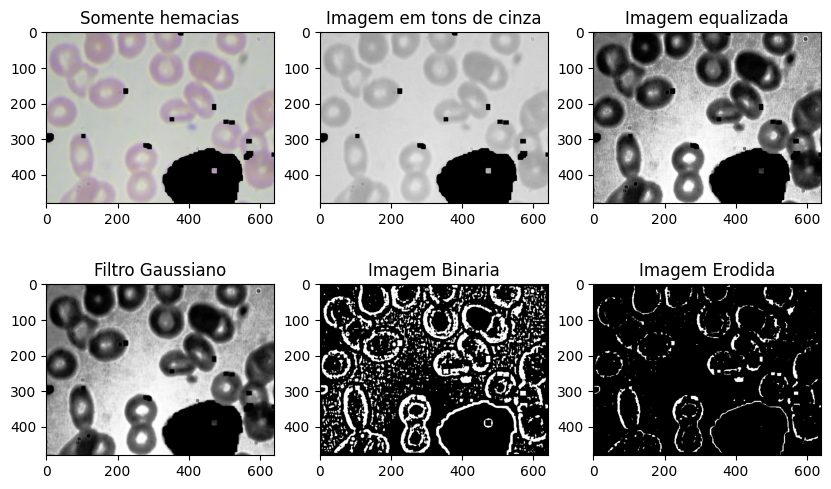

In [51]:
# Testando 

img_gray, img_eq, img_gaussian = preprocessamento(img_hemacias)
img_binary, img_erode, img_inverse = binariza_imagem(img_gaussian)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
fig.subplots_adjust(hspace= .2, wspace= .2)


ax[0][0].imshow(img_hemacias)
ax[0][0].set_title('Somente hemacias')

ax[0][1].imshow(img_gray, cmap='gray')
ax[0][1].set_title('Imagem em tons de cinza')

ax[0][2].imshow(img_eq, cmap='gray')
ax[0][2].set_title('Imagem equalizada')

ax[1][0].imshow(img_gaussian, cmap='gray')
ax[1][0].set_title('Filtro Gaussiano')

ax[1][1].imshow(img_binary, cmap='gray')
ax[1][1].set_title('Imagem Binaria')

ax[1][2].imshow(img_erode, cmap='gray')
ax[1][2].set_title('Imagem Erodida')



### Passo 3 - Metologia da detecção de circulos.


3.1 Metodologia usada para o projeto.

- 3.1.1. Foram selecionadas seis imagens que tivessem diferentes disposição de elementos e aparentavam cores diferentes umas das outras.

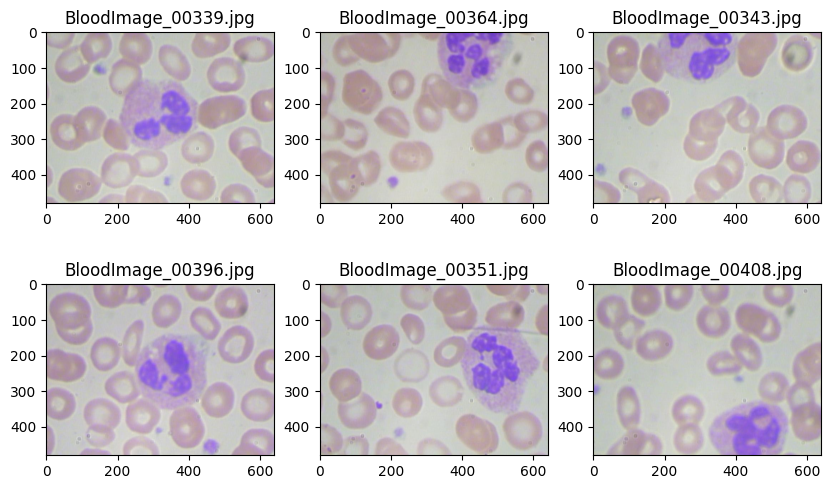

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
fig.subplots_adjust(hspace= .2, wspace= .2)

imgs = os.listdir('imgs')

def printImgs(imgs):
  l = 0
  c = 0
  for i in range(len(imgs[:6])):
      direc = 'imgs/' + imgs[i]
      if i == 3:
        l = 1
        c = 0
      imgread = io.imread(direc)
      
      ax[l][c].imshow(imgread)
      ax[l][c].set_title(imgs[i])
      c += 1

printImgs(imgs)

3.2 Foram feitos incansáveis ajustes manuais para obter a melhor acurácia e estabelecemos algumas condições para isso:

1. Ter a maior quantidade de verdadeiro positivos possíveis
2. Ter entre 0 e 4 falsos positivos FP
3. Ter mais de 55% do Verdadeiros positivos VP
4. Ter menos de 45% de falsos negativos FN

3.3 A função abaixo aplica a transformada circular de hough na imagem limiarizada, e a partir da grade de acumuladores gerada desenha círculos e seus respectivos pontos de centróides em cima das hemácias na imagem de entrada fazendo também a contagens delas.

Com base em vários testes manuais aplicamos a HoughCircles com esses parâmetros e será explicado no passo 3.2 e 3.3

In [53]:
def identifica_hemacias(img, binary_image):

    celulas = img.copy()

    circles = cv2.HoughCircles(binary_image,cv2.HOUGH_GRADIENT,1,68,
                             param1=33,param2=12,minRadius=30,maxRadius=58)
    
    hemacias_count = 0

    circles = np.uint32(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(celulas,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(celulas,(i[0],i[1]),2,(0,0,255),3)

        hemacias_count +=1

    
    return celulas, hemacias_count

3.4 Foram feitos incansáveis ajustes manuais para obter a melhor acurácia e estabelecemos algumas condições para isso:

1. Ter a maior quantidade de verdadeiro positivos possíveis
2. Ter entre 0 e 4 falsos positivos FP
3. Ter mais de 55% do Verdadeiros positivos VP
4. Ter menos de 45% de falsos negativos FN

3.5 Como você pode ver a transformada circular de hough foi aplicada dessa forma

```
circles = cv2.HoughCircles(binary_image,cv2.HOUGH_GRADIENT,1,68,
                             param1=33,param2=11,minRadius=30,maxRadius=58)
```

Uma breve explicação do porquê que chegamos a esses parametros

1. **O primeiro parâmetro** é a imagem binarizada
2. **O segundo parâmetro** indica que é usada a técnica do gradiente para detectar bordas na imagem. Ela explora as mudanças bruscaa de intensidade nos pixels da imagem para identificar as regiões onde ocorrem essas mudanças que frequentemente correspondem a bordas entre objetos na regiao. 
3. **O terceiro parametro**  1 indica que a resolução da imagem de entrada é mantida na aplicação da transformada de Hough. E claro que selecionamos 1
4. **quarto parâmetro** é a distância mínima entre os centros dos círculos detectados e se a distancia entre os centros for menor que que esse valor apenas o de maior confiança que sera adicionado, fizemos testes de 50 a 70 e vimos que o melhor valor para o nosso caso está entre 65 e 70 optamos por deixar em 68.
5. **O quinto parametro** param1=50 ele é usado para definir a sensibilidade do detector de bordas interno do HOUGH_GRADIENT. Valores menores de param1 resultarão em mais círculos sendo detectados (possivelmente com mais falsos positivos). testamos de 20 a 70 e 33 foi um bom numero para nós.
6. **O sexto parâmetro** para2=11 e é usado para definir o limite mínimp para a detecção de bordas. Valores menores de param2 resultarão em mais círculos sendo detectados, mas também em mais falsos positivos. Geralmente o param2 é igual a param3/3 e foi o que a gente fez aqui. Testamos ele de 5 a 33 e esse foi o melhor valor.
7. **O sétimo parâmetro**  minRadius=30 Este é o raio mínimo do círculo a ser detectado. Qualquer círculo com um raio menor do que este valor não será detectado. Testamos minRadius de 20 a 40, e 30 foi o melhor equilibrio para identificar com poucos falsos positivos, falsos negativos e uma boa quantidade de Verdadeiros positivos . 
8. **Oitavo parâmetro**  maxRadius=58 quer dizer que qualquer círculo com um raio maior do que este valor não será detectado .Testamos  valores entre 45 e 70 e 68 nos trouxe resultrados  bons com uma quantidade baixa de falsos positivose falsos negativos com uma boa quantidade de Verdadeiros positivos. 





- 3.5.1 Abaixo tem a aplicação dos métodos e exibição de todo o projeto

In [54]:
# Função que imprime todo o processo

def plota_todo_processo(dados):

    img_original = dados['img_original']
    img_hemacias = dados['img_hemacias']
    img_gray = dados['img_gray']
    img_eq = dados['img_eq']
    img_gaussian = dados['img_gaussian']

    img_binary = dados['img_binary']
    img_erode = dados['erode_close']
    inversa = dados['img_inverse']

    contagem = str (dados['hemacias_count'])
    hemacias = dados['hemacias']

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))
    fig.subplots_adjust(hspace= .2, wspace= .2)

    ax[0][0].imshow(img_original)
    ax[0][0].set_title('Original')

    ax[0][1].imshow(img_hemacias)
    ax[0][1].set_title('Somente hemacias')

    ax[0][2].imshow(img_gray, cmap='gray')
    ax[0][2].set_title('Imagem em tons de cinza')

    ax[1][0].imshow(img_eq, cmap='gray')
    ax[1][0].set_title('Imagem equalizada')

    ax[1][1].imshow(img_gaussian, cmap='gray')
    ax[1][1].set_title('Filtro Gaussiano')

    ax[1][2].imshow(img_binary, cmap='gray')
    ax[1][2].set_title('Imagem binaria')

    ax[2][0].imshow(img_erode, cmap='gray')
    ax[2][0].set_title('Imagem Erodida')

    ax[2][1].imshow(inversa, cmap='gray')
    ax[2][1].set_title('Inverso')

    ax[2][2].imshow(hemacias)
    ax[2][2].set_title('Hemacias identificadas: ' + contagem)
    

    plt.show()


In [55]:
def deteccao_main(img):
    
    img_hemacias = RemoveGlobulosBrancos(img)

    img_gray, img_eq, img_gaussian = preprocessamento(img_hemacias)

    img_binary, img_erode, img_inverse = binariza_imagem(img_gaussian)

    hemacias, hemacias_count =  identifica_hemacias(img, img_inverse)

    dados =  {'img_hemacias': img_hemacias,
              'img_original': img,
               'img_gray':img_gray,
               'img_eq': img_eq,
               'img_gaussian': img_gaussian,
               'img_binary': img_binary,
               'erode_close': img_erode,
               'img_inverse': img_inverse,
               'hemacias': hemacias,
               'hemacias_count': hemacias_count
               }
    
    plota_todo_processo(dados)
    return hemacias_count

BloodImage_00339.jpg


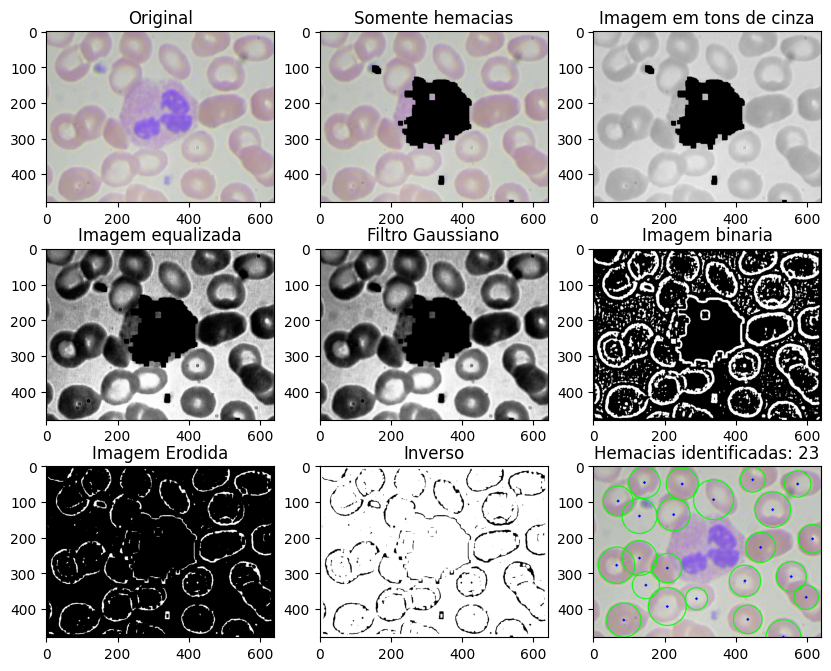

BloodImage_00364.jpg


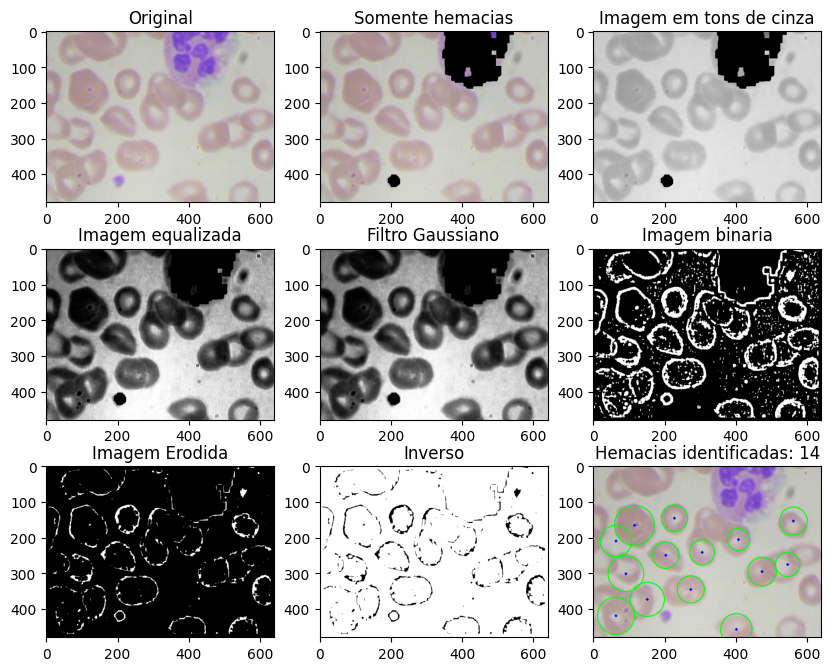

BloodImage_00343.jpg


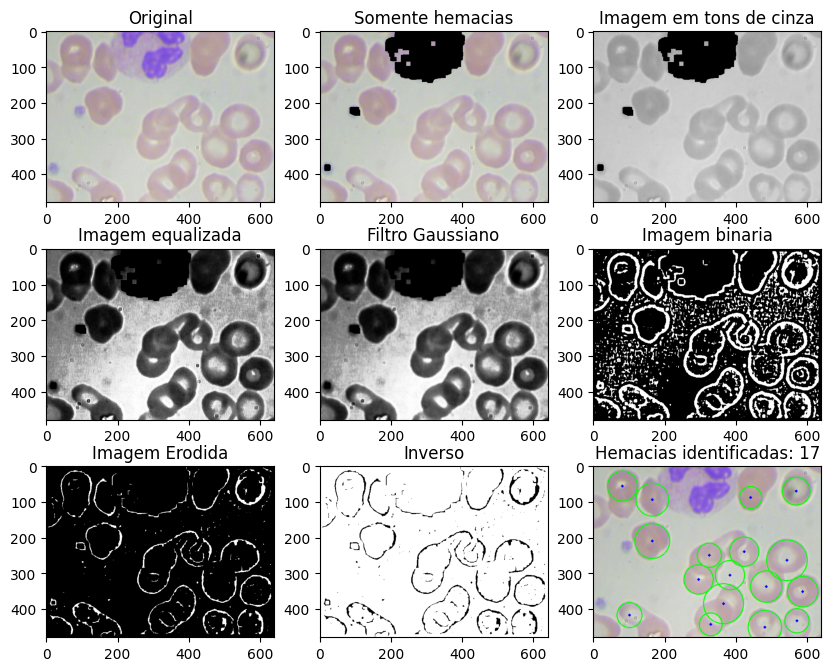

BloodImage_00396.jpg


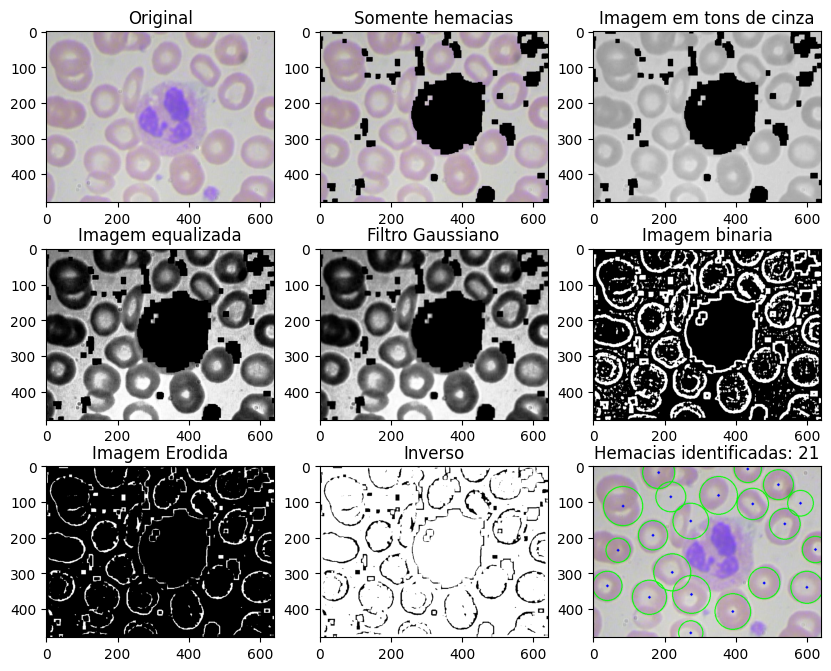

BloodImage_00351.jpg


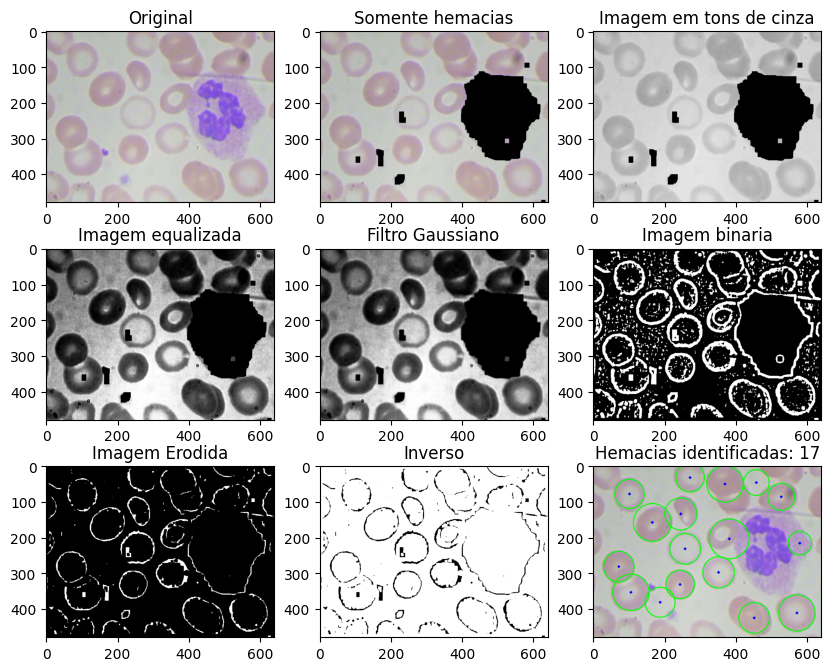

BloodImage_00408.jpg


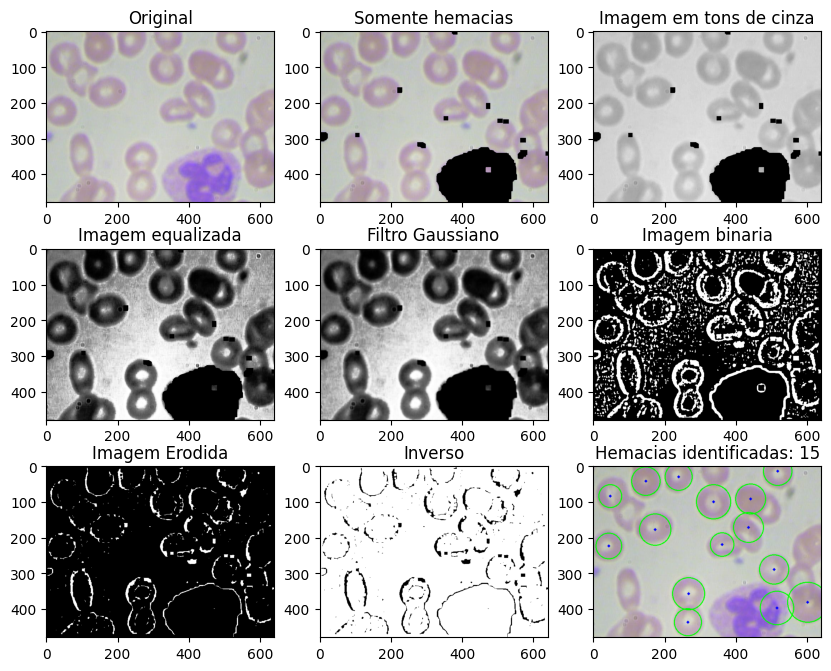

[('BloodImage_00339.jpg', 23), ('BloodImage_00364.jpg', 14), ('BloodImage_00343.jpg', 17), ('BloodImage_00396.jpg', 21), ('BloodImage_00351.jpg', 17), ('BloodImage_00408.jpg', 15)]


In [56]:
valores = []
for i in range(len(imgs)):
  direc = 'imgs/' + imgs[i]
  imgread = io.imread(direc)
  print(imgs[i])
  c = deteccao_main(imgread)
  valores.append((imgs[i], c))


print(valores)



### Passo 4 - Analise dos dados e Conclusão




4.1 Algumas observações antes da gente comecar

- - Cabe observar que se a gente abaixar a tolerancia de FN a quantidade de FP aumentam, trazendo a detecção em glóbulos brancos.
- - **Na contagem manual, evitamos contar hemácias nao apareceiam pelo menos 40% na imagem, pois náo há uma certeza de que sejam hemácias**
- - Optamos pela contagem somente das hemacias, claro que tiveram alguns resultados que contou um circulo em uma cavidade em um leucócito (falso positivo)
- - Obter resultados somente com as técnicas de processamento de imagens não nos trás bons resultados para diferentes imagens.

In [57]:
# Conjunto de dados para a analise os que estao em zero serao preenchidos.
resultados = {
     'BloodImage_00339.jpg':  {'FN':  7, 'FP': 2, 'VP': 21, 'qnt existente': 28, 'Taxa VP/Recall': 0, 'Taxa FN': 0, 'Precisao': 0,  'F1 Score': 0}, 
     'BloodImage_00364.jpg':  {'FN':  9, 'FP': 0, 'VP': 13, 'qnt existente': 22,  'Taxa VP/Recall': 0, 'Taxa FN': 0, 'Precisao': 0,  'F1 Score': 0}, 
     'BloodImage_00343.jpg':  {'FN':  6, 'FP': 1, 'VP': 16, 'qnt existente': 22 ,  'Taxa VP/Recall': 0, 'Taxa FN': 0, 'Precisao': 0, 'F1 Score': 0}, 
     'BloodImage_00396.jpg':  {'FN':  8, 'FP': 2, 'VP': 19, 'qnt existente': 27,  'Taxa VP/Recall': 0, 'Taxa FN': 0, 'Precisao': 0,  'F1 Score': 0} , 
     'BloodImage_00351.jpg': {'FN':  9, 'FP': 2, 'VP': 15, 'qnt existente': 24 ,  'Taxa VP/Recall': 0, 'Taxa FN': 0, 'Precisao': 0,  'F1 Score': 0}, 
     'BloodImage_00408.jpg':  {'FN':  9, 'FP': 1, 'VP': 14, 'qnt existente': 23 ,  'Taxa VP/Recall': 0, 'Taxa FN': 0, 'Precisao': 0,'F1 Score': 0} 
     }


- 4.2 Calculando as taxas

- -  taxaFN(FN, VP): Calcula a taxa de Falsos Negativos (FN) em porcentagem 
- - taxaVP(VP, FN): Calcula a taxa de Verdadeiros Positivos (VP) em porcentagem
- - precisao(VP, FP): Calcula a precisão do modelo, basicamente é o quanto o modelo acerta o que é hemácia de fato, quanto mais proximo de 1 melhor.
- - F1Score(precisao, recall): média harmônica da precisão e da revocação. Ela fornece uma única medida que combina precisão e recall em um único número. O F1 Score varia de 0 a 1, onde 1 indica um modelo perfeito e 0 indica o pior desempenho possível. 

In [58]:
# Calculos das taxas
def taxaFN(FN, VP):
  return "{:.2f}%".format((FN / (FN + VP)) * 100)

def taxaVP(VP, FN):
  c = VP / (VP + FN)
  return "{:.2f}%".format(c * 100), c

def precisao(VP, FP):
  c = VP/ (VP + FP)
  return "{:.2f}".format(c), c


def F1Score(precisao, recall):
  return 2 * ((precisao * recall) / (precisao + recall))

- 4.3 Aplicação de das taxas e conclusão

Abaixo está uma tabela com todos os cálculos:

In [59]:
for key, value in resultados.items():
    s, n = precisao(value['VP'], value['FP'])
    srecall, nrecall = taxaVP(value['VP'], value['FN'])
    value['Taxa FN'] = taxaFN(value['FN'], value['VP'])
    value['Taxa VP/Recall'] = srecall
    value['Precisao'] = s
    value['F1 Score'] = F1Score(n, nrecall)
  

pd.set_option('display.width', 1000)

df = pd.DataFrame.from_dict(resultados, orient='index')


print(df)


                      FN  FP  VP  qnt existente Taxa VP/Recall Taxa FN Precisao  F1 Score
BloodImage_00339.jpg   7   2  21             28         75.00%  25.00%     0.91  0.823529
BloodImage_00364.jpg   9   0  13             22         59.09%  40.91%     1.00  0.742857
BloodImage_00343.jpg   6   1  16             22         72.73%  27.27%     0.94  0.820513
BloodImage_00396.jpg   8   2  19             27         70.37%  29.63%     0.90  0.791667
BloodImage_00351.jpg   9   2  15             24         62.50%  37.50%     0.88  0.731707
BloodImage_00408.jpg   9   1  14             23         60.87%  39.13%     0.93  0.736842



- 4.4 Conclusao, abaixo tem uma tabela com a média de cada coluna, vamos nos atentar para dois dados  importante que resumem nosso estudo, são eles:


- - Precisao de 93%˜ que indica que podemos confiar 0.93 que o que nossa solução está identificado são realmente hemácias
- - F1 Score de 77%˜ sugere que o modelo de detecção está alcançando um bom equilíbrio entre precisão e recall na identificação de hemácias nas imagens analisadas. 


In [60]:
df['Taxa FN'] = df['Taxa FN'].str[:-1].astype(float) / 100
df['Taxa VP/Recall'] = df['Taxa VP/Recall'].str[:-1].astype(float) / 100
df['Precisao'] = df['Precisao'].astype(float)
df['F1 Score'] = df['F1 Score'].astype(float)

# Calculando a média de cada coluna
media_por_coluna = df.mean()


print("\nMédia de cada coluna:\n", media_por_coluna)


Média de cada coluna:
 FN                 8.000000
FP                 1.333333
VP                16.333333
qnt existente     24.333333
Taxa VP/Recall     0.667600
Taxa FN            0.332400
Precisao           0.926667
F1 Score           0.774519
dtype: float64



Observação final: Obtivemos resultados satisfatórios, porém menos confiáveis em comparação com técnicas de aprendizado de máquina. Nossa solução apresenta aproximadamente 70% de confiança, enquanto as soluções de aprendizado de máquina para esse tipo de problema alcançam valores acima de 0.9.